load packages

In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# The Data
Split the dataset in to train and test. We are using training data only for EDA.

In [3]:
df = pd.read_csv('train.tsv', sep = '\t')

In [4]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [5]:
train.shape, test.shape

((1185372, 8), (297163, 8))

In [6]:
##EDA
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1185372 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1185372 non-null int64
name                 1185372 non-null object
item_condition_id    1185372 non-null int64
category_name        1180324 non-null object
brand_name           679638 non-null object
price                1185372 non-null float64
shipping             1185372 non-null int64
item_description     1185369 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 81.4+ MB


Price

In [8]:
train.price.describe()

count    1.185372e+06
mean     2.674376e+01
std      3.849110e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [9]:

plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Shipping

In [10]:
train['shipping'].value_counts() / len(train)

0    0.552686
1    0.447314
Name: shipping, dtype: float64

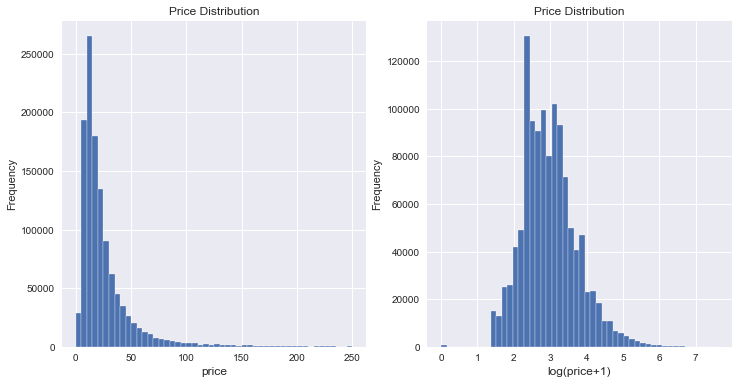

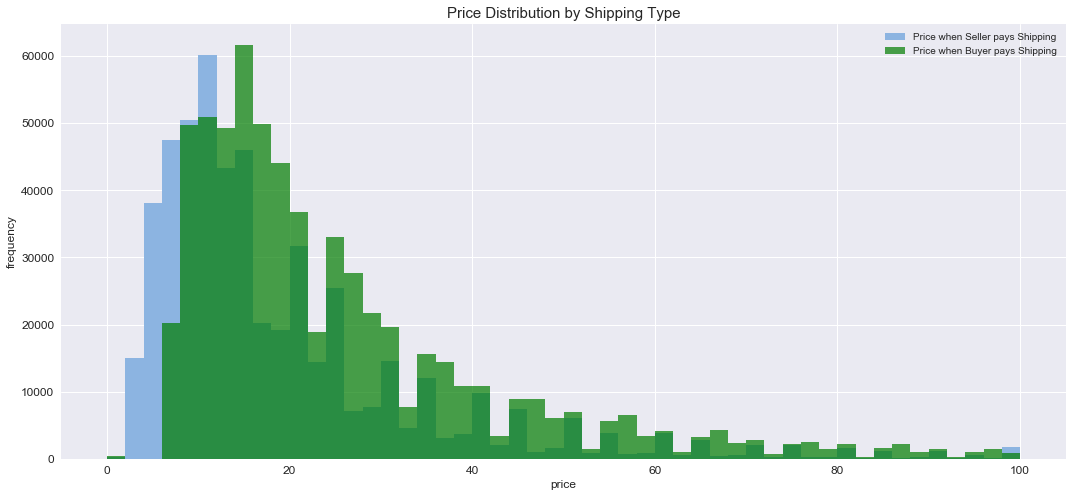

In [11]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [12]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.55 if seller pays shipping
The average price is 30.14 if buyer pays shipping


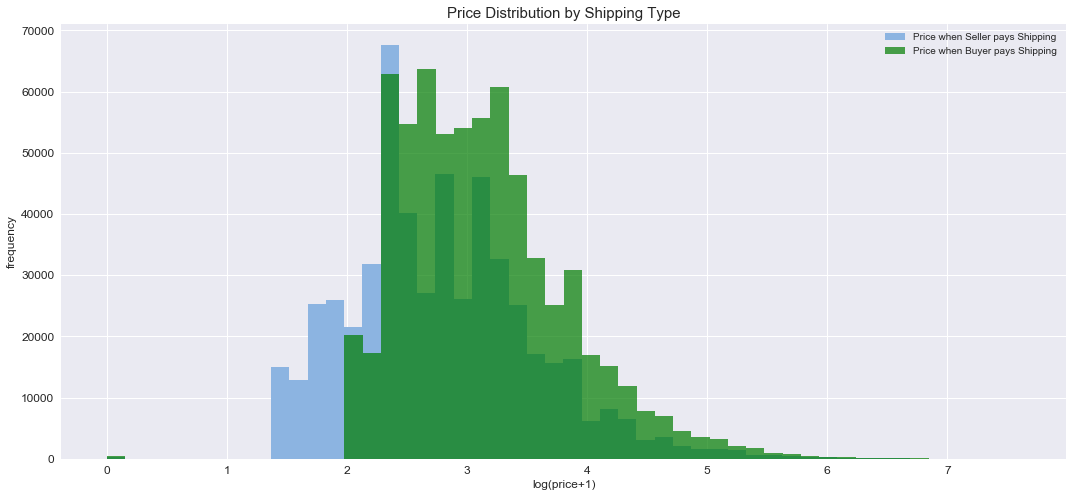

In [13]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

#### Category Names

In [14]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1263 unique values in category name column


In [15]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48315
Women/Tops & Blouses/T-Shirts                                  37164
Beauty/Makeup/Face                                             27480
Beauty/Makeup/Lips                                             23943
Electronics/Video Games & Consoles/Games                       21189
Beauty/Makeup/Eyes                                             20044
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19780
Women/Underwear/Bras                                           17063
Women/Tops & Blouses/Tank, Cami                                16228
Women/Tops & Blouses/Blouse                                    16095
Name: category_name, dtype: int64

## Item condition vs. Price

In [20]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

# LightGBM
Settings

In [19]:

NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [21]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 5048 items that do not have a category name.


In [22]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 505734 items that do not have a brand name.


In [23]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 3 items that do not have a description.


In [24]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [25]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [26]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [27]:
df = pd.read_csv('train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

In [28]:
# Drops rows where price=0
train = train[train.price != 0].reset_index(drop=True)

In [30]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [31]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [32]:
merge.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,train_id
0,missing,Men/Tops/T-shirts,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,1
2,Target,Women/Tops & Blouses/Blouse,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,2
3,missing,Women/Jewelry/Necklaces,1,Complete with certificate of authenticity,24K GOLD plated rose,44.0,0,4
4,missing,Women/Other/Other,3,"Banana republic bottoms, Candies skirt with ma...",Bundled items requested for Ruie,59.0,0,5


In [33]:
##Count vectorize name and category name columns.
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [34]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

#### TFIDF Vectorize item_description column.

In [36]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [35]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [38]:
#Create dummy variables for item_condition_id and shipping columns.
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [39]:
#Create sparse merge.
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [40]:
sparse_merge.shape

(1481827, 72752)

In [41]:
#Remove features with document frequency <=1.
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [42]:
sparse_merge.shape

(1481827, 72286)

In [43]:
#Separate train and test data from sparse merge.

X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]



In [44]:
train_X = lgb.Dataset(X, label=y)

In [45]:

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

## Training
#Training a model requires a parameter list and data set. And training will take #a while.

In [ ]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

## Predictions 

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)